# Exercise 4

### Necessary imports

In [249]:
import os
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

### Dataset loading

In [250]:
directory = 'dataset/20_NGs_400'
list_of_vectors = []
target = []
target_names = []
i = 0

for filenames in os.listdir(directory):
    for file in os.listdir(directory + "/" + filenames):
        f = open(directory + "/" + filenames + "/" + file, "r")
        target.append(i)
        list_of_vectors.append(f.read())
    target_names.append(filenames)
    i += 1

### Creating the FVM with CountVectorizer

In [251]:
vectorizer = CountVectorizer(stop_words='english')
vectors_dataset = vectorizer.fit_transform(list_of_vectors)

In [252]:
def count_doc_positives(target: list, target_class: int) -> int:
    return target.count(target_class)

### Defining the rocchio method for obtaining the vector of features for each classes

In [253]:
def rocchio_method(train: list, target: list, num_class: int, beta: int, gamma: int) -> list:
    profiles = []
    for i in range(num_class):
        pos = []
        neg = []
        pos_word_num = []
        neg_word_num = []
        for index, x in enumerate(train):
            if(target[index] == i):
                pos.append(x)
            else:
                neg.append(x)
    
        positive_examples = count_doc_positives(target, i)
        negative_examples = len(target) - positive_examples
        
        pos_word_num = np.array([sum(x) for x in zip(*pos)]) / positive_examples
        neg_word_num = np.array([sum(x) for x in zip(*neg)]) / negative_examples

        profiles.append((beta * pos_word_num) - (gamma * neg_word_num))
    return profiles

### Defining the function for predicting the class of a document, comparing the cosine similarity of the document with the vectors of profiles given by Rocchio Method

In [254]:
def predict_rocchio(profiles: list, test: list, misure: str) -> list:
    prediction = []

    for x in test:
        best_similarity = 100000
        best_vector = None
        for index, profile in enumerate(profiles):
            similarity = distance.cosine(x, profile) if misure == 'cosine' else distance.euclidean(x, profile)
            if(similarity < best_similarity):
                best_similarity = similarity
                best_vector = index
        prediction.append(best_vector)
    return prediction

### Splitting the dataset into training and test set and getting the profiles with Rocchio Method and the predictions for the test set

In [255]:
X_train, X_test, y_train, y_test = train_test_split(vectors_dataset.toarray(), target, test_size=0.1, random_state=42)
profiles = rocchio_method(X_train, y_train, len(target_names), 16, 8)
predict_value_cosine = predict_rocchio(profiles, X_test, misure="cosine")
predict_value_euclidean = predict_rocchio(profiles, X_test, misure="euclidean")

In [256]:
# I calculate the accuracy, f1, precision and recall score for a single fold
print("--------------------")
print("Cosine")
print("Accuracy Score: ", accuracy_score(y_test, predict_value_cosine))
print("Precision Score: ", precision_score(y_test, predict_value_cosine, average='macro'))
print("Recall Score: ", recall_score(y_test, predict_value_cosine, average='macro'))
print("F1 Score: ", f1_score(y_test, predict_value_cosine, average='macro'))
print("--------------------")
print("Euclidean")
print("Accuracy Score: ", accuracy_score(y_test, predict_value_euclidean))
print("Precision Score: ", precision_score(y_test, predict_value_euclidean, average='macro'))
print("Recall Score: ", recall_score(y_test, predict_value_euclidean, average='macro'))
print("F1 Score: ", f1_score(y_test, predict_value_euclidean, average='macro'))
print("--------------------")

--------------------
Cosine
Accuracy Score:  0.475
Precision Score:  0.475
Recall Score:  0.42833333333333334
F1 Score:  0.406991341991342
--------------------
Euclidean
Accuracy Score:  0.1
Precision Score:  0.06386554621848739
Recall Score:  0.08823529411764706
F1 Score:  0.048503611971104234
--------------------


### Plotting the confusion matrix for the test set

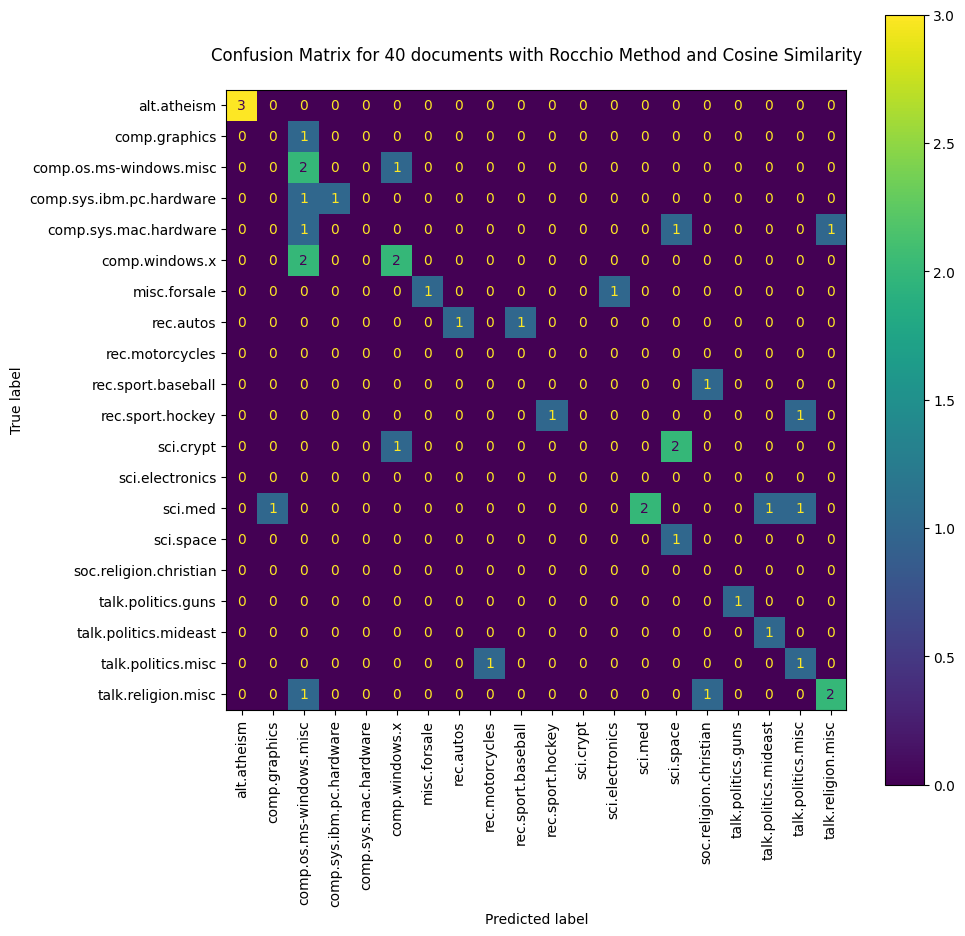

In [257]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predict_value_cosine, ax=ax, labels=[x for x in range(20)], display_labels=target_names, xticks_rotation='vertical')
_ = ax.set_title(
    f"Confusion Matrix for {len(y_test)} documents with Rocchio Method and Cosine Similarity\n"
)

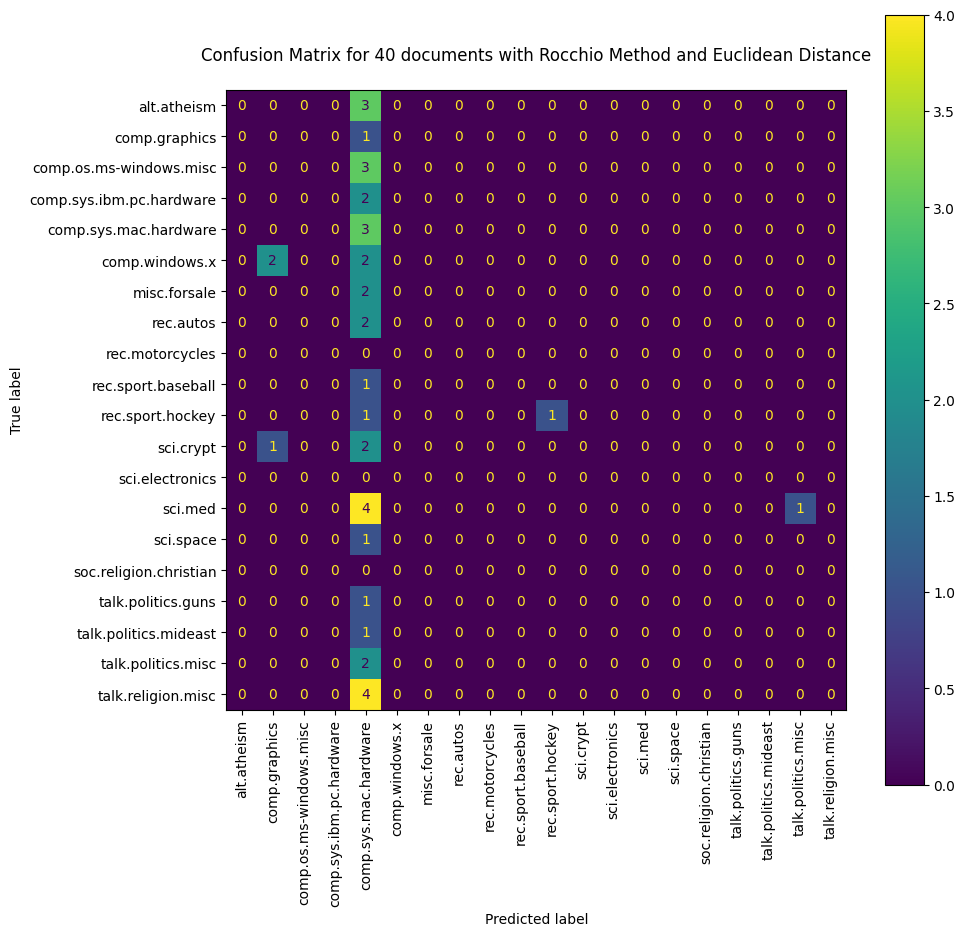

In [258]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predict_value_euclidean, ax=ax, labels=[x for x in range(20)], display_labels=target_names, xticks_rotation='vertical')
_ = ax.set_title(
    f"Confusion Matrix for {len(y_test)} documents with Rocchio Method and Euclidean Distance\n"
)

### Implementing the cross validation for the dataset with 10 folds and getting the mean accuracy

We did some testing and realized that the best value for parameter beta is 16 and the best value for parameter gamma is 4.

In [259]:
accuracy_scores_cosine = []
f1_scores_cosine = []
precision_scores_cosine = []
recall_scores_cosine = []
accuracy_scores_euclidean = []
f1_scores_euclidean = []
precision_scores_euclidean = []
recall_scores_euclidean = []

for i in random.sample(range(0, 10000), 10):
    X_train, X_test, y_train, y_test = train_test_split(vectors_dataset.toarray(), target, test_size=0.1, random_state=i)
    profiles = rocchio_method(X_train, y_train, 20, 16, 8)
    predict_value = predict_rocchio(profiles, X_test, misure="cosine")
    accuracy_scores_cosine.append(accuracy_score(y_test, predict_value))
    f1_scores_cosine.append(f1_score(y_test, predict_value, average='macro'))
    precision_scores_cosine.append(precision_score(y_test, predict_value, average='macro'))
    recall_scores_cosine.append(recall_score(y_test, predict_value, average='macro'))
    predict_value = predict_rocchio(profiles, X_test, misure="euclidean")
    accuracy_scores_euclidean.append(accuracy_score(y_test, predict_value))
    f1_scores_euclidean.append(f1_score(y_test, predict_value, average='macro'))
    precision_scores_euclidean.append(precision_score(y_test, predict_value, average='macro'))
    recall_scores_euclidean.append(recall_score(y_test, predict_value, average='macro'))

print("--------------------")
print("Cosine Similarity")
print("Mean Accuracy Score: ", np.mean(accuracy_scores_cosine))
print("Mean Precision Score: ", np.mean(precision_scores_cosine))
print("Mean Recall Score: ", np.mean(recall_scores_cosine))
print("Mean F1 Score: ", np.mean(f1_scores_cosine))
print("--------------------")
print("Euclidean Distance")
print("Mean Accuracy Score: ", np.mean(accuracy_scores_euclidean))
print("Mean Precision Score: ", np.mean(precision_scores_euclidean))
print("Mean Recall Score: ", np.mean(recall_scores_euclidean))
print("Mean F1 Score: ", np.mean(f1_scores_euclidean))
print("--------------------")

--------------------
Cosine Similarity
Mean Accuracy Score:  0.545
Mean Precision Score:  0.5118973782495455
Mean Recall Score:  0.5160457516339869
Mean F1 Score:  0.4763640955230223
--------------------
Euclidean Distance
Mean Accuracy Score:  0.08249999999999999
Mean Precision Score:  0.034425835483457276
Mean Recall Score:  0.0677141382868937
Mean F1 Score:  0.024176681184911945
--------------------
